# kalman filter implementation for inertial navigation
lots of code from https://github.com/dhruvpatel44/Kalman_Filter

# Imports

In [1]:
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy import integrate
from scipy import misc



# make graphs cute 

In [2]:
%matplotlib inline

# List Files

In [3]:
ls

 gamerrobot.csv  'kalman filter.ipynb'   notebook.ipynb
 init.ipynb       newFixedData.csv       posevaccelerometer.csv


# obtain data 

In [4]:
data = pd.read_csv("newFixedData.csv")
true_pose = data.x
measured_accel = data.yaccel
dt = 1 #sum(data.time) / len(data.time)
z = np.c_[data.yaccel]

# data format 


In [5]:
data.head(10)

,x,y,time,xaccel,yaccel
0,0.000000,0.000000,0.026,0.00,-0.61
1,0.025628,0.025628,0.021,0.22,-0.83
2,0.141620,0.141620,0.024,3.45,3.20
3,0.311256,0.311256,0.027,2.99,-1.92
4,0.524226,0.524226,0.026,5.08,-2.33
5,0.859760,0.859760,0.026,1.02,5.18
6,1.272983,1.272983,0.030,5.14,-3.94
7,1.773169,1.773169,0.028,1.83,0.43
8,2.374726,2.374726,0.028,2.23,-1.19
9,3.012588,3.012588,0.032,0.51,-0.88


# not cute yet but will be cute integrals

In [6]:
def integral(time, data):
    integral_sum = 0
    integrations = []
    for i in range(0,len(data)):
        integral_sum = ((data[i] + data[i - 1]) / 2 ) *  0.2
        # np.trapz(0.2, data[0:i+1])
        # PLEASE WORK ^
        # PLEASE PLEASE FIX YOURSELF
        # DUMB INTEGRATION CRINGE
        integrations.append(integral_sum)
    return integrations 
def integral_square(time, data):
    integral_sum = 0
    integrations = []
    for i in range(0,len(data)):
        #print(f"data: {len(data[:i])} time: {len(time[:i])}")
        integral_sum += data[i] *  0.2
        integrations.append(integral_sum)
    return integrations 
def derivative(time, data):
    derivatives = []
    for i in range(1,len(data)):
        slope = (data[i] - data[i - 1]) / 0.2
        derivatives.append(slope)
    return derivatives


# Reference Data 

Text(0.5, 1.0, 'True Velocity vs True Acceleration vs True Position')

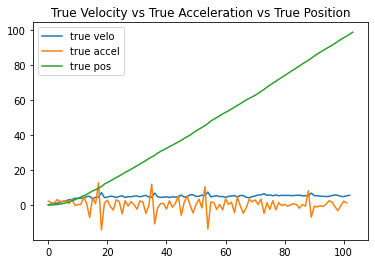

In [7]:
true_velo = derivative(data.time, data.x)
true_accel = derivative(data.time, true_velo)
true_pos = data.x
plt.plot(true_velo,label = "true velo")
plt.plot(true_accel,label = 'true accel')
plt.plot(true_pos,label = 'true pos')
plt.legend()
plt.title("True Velocity vs True Acceleration vs True Position")

<b>Defining Prediction Function</b>

In [8]:
def Prediction(x_t_1, P_t_1, F_t, Q_t):
    x_t = F_t.dot(x_t_1)
    P_t = np.diag(np.diag(F_t.dot(P_t_1).dot(F_t.T))) + Q_t
    return x_t, P_t


# defining update function


In [9]:
def Update(x_t, P_t, Z_t, R_t, H_t):
    S = np.linalg.inv( H_t.dot(P_t).dot(H_t.T) + R_t )
    K = P_t.dot(H_t.T).dot(S)

    x_t = x_t + K.dot(Z_t - H_t.dot(x_t))
    P_t = P_t - K.dot(H_t).dot(P_t)

    return x_t, P_t


# Defining the Variables and Matrices

In [10]:
# Transition Matrix
F_t = np.array([    [1, dt, (1/2)*(dt**2)],
                    [0, 1, dt],
                    [0, 0, 1]      ])


# Process Covariance
process_var = 0.44
Q_t = process_var * np.array([[(dt**4)/4, (dt**3)/2, (dt**2)/2],
                                 [(dt**3)/2, 2*(dt**3), (dt**2)],
                                 [(dt**2)/2, (dt**2), (dt**2)]])

# Measurement Covariance
R_t = 0.77

# Measurement Matrix
H_t = np.array([ [0, 0, 1] ])


# initial state & Covariance

In [11]:
# Initial State
x_t = np.array([ [0], [0], [0] ])

# Initial Covariance State 
P_t = 1 * np.identity(3)

In [12]:

# Empty Lists to save the estimated states
kalman_pos =[]
kalman_vel = []
kalman_acc = []

# Main Kalman Loop

In [13]:
for i in range(z.shape[0]):
    
    # Prediction Step
    x_t, P_t = Prediction(x_t,P_t,F_t,Q_t)

    # Reshaping the measurement data
    Z_t = z[i].transpose()
    Z_t = Z_t.reshape(Z_t.shape[0], -1)

    # Update Step
    x_t, P_t = Update(x_t,P_t,Z_t,R_t,H_t)

    kalman_pos.append(x_t[0])
    kalman_vel.append(x_t[1])
    kalman_acc.append(x_t[2])

In [14]:
print(" Final Filter State Matrix : \n\n", x_t)


 Final Filter State Matrix : 

 [[-1.82808977e+03]
 [-3.83714831e+01]
 [-3.50206953e-01]]


In [15]:


#Plotting
len(data.time)
len(kalman_acc)
kalman_acc = np.concatenate(kalman_acc).ravel()
kalman_vel = integral(data.time, kalman_acc)
kalman_pos = integral(data.time, kalman_vel)

x = np.linspace(0, 20, 200)



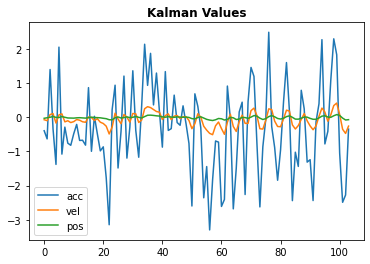

In [16]:
plt.title('Kalman Values', fontweight='bold')
plt.plot(kalman_acc, label = "acc")
plt.plot(kalman_vel, label = "vel")
plt.plot(kalman_pos, label = "pos")
plt.legend()


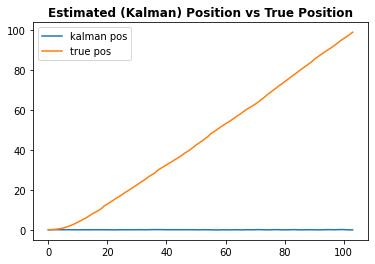

In [17]:

plt.title('Estimated (Kalman) Position vs True Position', fontweight='bold') 
plt.plot(kalman_pos,label = "kalman pos")
plt.plot(true_pos, label = 'true pos')
plt.legend()

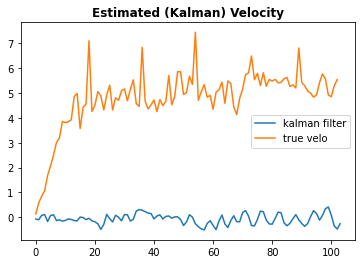

In [18]:

plt.title('Estimated (Kalman) Velocity', fontweight='bold') 
plt.plot(kalman_vel,label = "kalman filter")
plt.plot(true_velo, label = "true velo")
plt.legend()


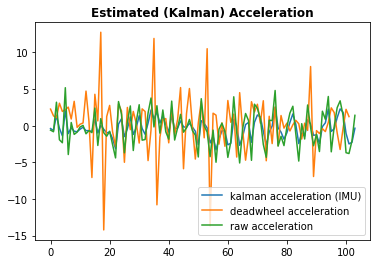

In [19]:
plt.title('Estimated (Kalman) Acceleration', fontweight='bold') 
plt.plot(kalman_acc,label = "kalman acceleration (IMU)")
plt.plot(true_accel,label = "deadwheel acceleration")
plt.plot(data.yaccel,label = "raw acceleration")
plt.legend()


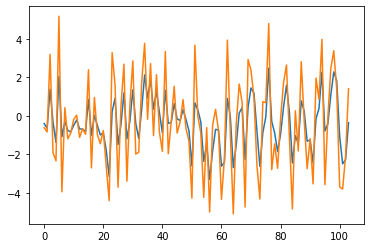

In [20]:
plt.plot(kalman_acc)
plt.plot(data.yaccel)

In [21]:
np.array(data.time[2::]).shape
np.array(true_accel).shape

(102,)

Text(0.5, 1.0, 'true position vs deriviating and reintegrating')

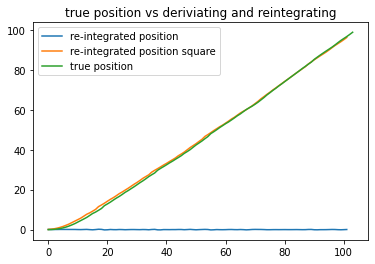

In [22]:
plt.plot(integral(data.time[2::],integral(data.time[2::],true_accel)),label = "re-integrated position")
plt.plot(integral_square(data.time,integral_square(data.time,true_accel)),label = "re-integrated position square")

plt.plot(data.x, label = "true position")
plt.legend()
plt.title("true position vs deriviating and reintegrating")